In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

import seaborn as sns

from scipy.ndimage.interpolation import shift

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

import time
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam,SGD


from keras import regularizers

import timeit
from multiprocessing import Pool
from sklearn.model_selection import ParameterGrid

import pickle
import datetime

from sklearn.externals import joblib
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import backend as K

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import itertools

from mpl_toolkits.mplot3d import Axes3D

In [78]:
seed = 7
np.random.seed(seed)

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [98]:
[np.nan]*14

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [99]:
def count(series, spanne):
    
    c = [np.nan]*spanne
    
    for i in range(len(series)-spanne):
        anzahl = series.iloc[i:i+spanne].sum()
        c.append(anzahl)
        
    return c        

In [80]:
def durchbruch(series, spanne):
    
    dW = [np.nan]*spanne
    dU = [np.nan]*spanne
    s = [np.nan]*spanne
    
    for i in range(len(series)-spanne):
        
        wert = series.iloc[i+spanne]
        #print "Wert:", wert
        
        if i ==0:
           
            zeitraum = series.iloc[i:i+spanne]
            widerstand = zeitraum.max()
            unterstuetzung = zeitraum.min()
            
            #print "Widerstand", widerstand
            #print "Unterstuetzung", unterstuetzung
            
            if wert <= widerstand and wert >= unterstuetzung:
            
                dW.append(0)
                dU.append(0)
                s.append(1)
                #print (0,0,1)
            
            elif wert> widerstand:
            
                dW.append(1)
                dU.append(0)
                s.append(0)
                #print (1,0,0)
        
            elif wert <unterstuetzung:
            
                dW.append(0)
                dU.append(1)
                s.append(0)
                #print (0,1,0)
            
            #print '-----'
            
            
        else:
            
            #print "Widerstand", widerstand
            #print "Unterstuetzung", unterstuetzung
            
            if wert <= widerstand and wert >= unterstuetzung:
            
                dW.append(0)
                dU.append(0)
                s.append(1)
                #print (0,0,1)

            elif wert> widerstand:

                dW.append(1)
                dU.append(0)
                s.append(0)
                #print (1,0,0)

            elif wert <unterstuetzung:

                dW.append(0)
                dU.append(1)
                s.append(0)
                #print (0,1,0)
            
            if wert >widerstand:
                unterstuetzung = widerstand
                widerstand = wert
            
            elif wert < unterstuetzung:
                
                widerstand = unterstuetzung
                unterstuetzung = wert
                
            #print "Widerstand neu", widerstand
            #print "Unterstuetzung neu", unterstuetzung 
            #print "------"
        
         
    return dW, dU, s

In [81]:
dW, dU, s = durchbruch(data['Close_prev'], 14)

In [82]:
def aroon(series, spanne):
    
    aroon_up = [np.nan]*spanne
    aroon_down = [np.nan]*spanne
    
    for i in range(len(series)-spanne):

        zeitraum = series.iloc[i:i+spanne]
        start = zeitraum.iloc[0]
        maximum = zeitraum.max()
        minimum = zeitraum.min()
        
        imax = False
        imin = True
        indexMax=0
        indexMin=0
        
        for j in range(len(zeitraum)):
            if zeitraum.iloc[j]==maximum:
                indexMax = spanne-j
                imax=True
            
            elif zeitraum.iloc[j]==minimum:
                indexMin = spanne-j
                imin = True
                
                break
                
        if imax == True:
            aroon_up_new = 100.0 * ((float(spanne)-indexMax)/float(spanne))
            
        else:
            aroon_up_new = 0
            
        aroon_up.append(aroon_up_new)
        
        
        if imin ==True:
            aroon_down_new = 100.0 * ((float(spanne)-indexMin)/float(spanne))
        else:
            aroon_down_new = 0
                
        aroon_down.append(aroon_down_new)
            
        
    return aroon_up, aroon_down                

In [83]:
# Berechnung "Relative Strength Index"

def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] )
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] )
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(ignore_na=True, min_periods = 0, adjust=False, com=period-1).mean() / d.ewm(ignore_na=True, min_periods=0,
                                                                                   adjust=False, com = period-1).mean()
    # Korrektur auf neue Pandas Version!
    #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
    #pd.stats.moments.ewma(d, com=period-1, adjust=False)
    # .ewm(ignore_na=False,min_periods=0,adjust=False,com=13).mean()
    
    return 100 - 100 / (1 + rs)

In [115]:
def data_prep(pathIN, pathOUT):
    
    data = pd.read_csv(pathIN)
    
    neu =pd.DataFrame(data['Close'].shift(+1), columns=['Close'])
    neu['Open'] = data.Open
    neu['Volume_Prev'] = data.Volume.shift(+1)
    neu['Close_Next'] = neu['Close'].shift(-1)
    neu.columns = ['Close_prev','Open_today','Volume_prev','Close_today']
    #neu['Rolling_mean_close'] = neu['Close_prev'].rolling(10).mean()
    #neu['Rolling_mean_open'] = neu['Open_today'].rolling(10).mean()
    neu['RSI'] = RSI(neu['Close_prev'], 14)
    au, ad = aroon(neu['Close_prev'], 5)
    neu['aroon_up']=au
    neu['aroon_down']=ad
    neu['aroon_up_mean']= neu['aroon_up'].rolling(5).mean()
    neu['aroon_down_mean']= neu['aroon_down'].rolling(5).mean()
    neu["signal_up"]=np.where(neu['aroon_up']>75, 1, 0)
    neu["signal_down"]=np.where(neu['aroon_down']>75, 1, 0)
    dW, dU, s = durchbruch(neu['Close_prev'], 14)
    neu['Widerstand'] = dW
    neu['Unterstuetzung'] =dU
    neu['Stabil']= s
    neu['countW'] = count(neu['Widerstand'],5)
    neu['countU'] = count(neu['Unterstuetzung'], 5)
    neu['countS'] = count(neu['Stabil'], 5)
    neu['Trend'] = np.where((neu['Close_prev']-neu['Close_today'])<0, 1, 0)
    neu.drop(['Close_today', 'Open_today'], axis=1,inplace=True)
    neu.dropna(axis=0,inplace=True)
    
    neu.to_pickle(pathOUT)
    X,Y = create3D(pathOUT, 1)
    pathX = 'X_zalando'
    pathY = 'Y_zalando'
    np.save(pathX,X)
    np.save(pathY,Y)
    
    return pathX, pathY

In [101]:
def create3D(path,window):
    
    data = pd.read_pickle(path)
    
    mm = MinMaxScaler((0,1))
    mm.fit(data[data.columns])#.reshape(-1,1))
    data = mm.transform(data[data.columns])#.reshape(-1,1))
    X = data
    
    #print X
    #print X.shape
     
    X_neu = []

    for i in range(window, len(X)-window, 1):

        x = X[:,:X.shape[1]-1][i-window:i]
        X_neu.append(x)
    
    X_a = np.asarray(X_neu)
    #print X_a
    X_a= np.reshape(X_a,(X_a.shape[0],X_a.shape[1],X_a.shape[2]))
    print len(X_a), X_a.shape
    
    X_y=X[:,X.shape[1]-1]#3]
    #print X_y
    Y = []

    for j in range(window, len(X)-window, 1):

        y = X_y[j:j+window]
        Y.append(y)

    Y_a = np.asarray(Y)
    Y_a=Y_a.reshape((Y_a.shape[0], Y_a.shape[1]))

    print len(Y_a), Y_a.shape
    
    #filename = 'mm_zalando.sav'
    #joblib.dump(mm, filename)
    
    return X_a, Y_a

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [103]:
def showConfusionMatrix(cm, labels, normalize):
    plt.figure()
    plot_confusion_matrix(cm, labels, normalize=normalize)
    plt.show()

In [104]:
def printParams(params):
    print_params={}
    for p in params:
        
        if type(params[p]) is np.ndarray:
            'do nothing'
            #p
        elif type(params[p]) is pd.DataFrame:      
            'do nothing'
            
        elif type(params[p]) is list:      
            'do nothing'
            
        else:
            print_params[p]=params[p]

    return print_params

In [105]:
def getData1(pathX, pathY):
    
    
    dataX = np.load(pathX)
    dataY = np.load(pathY)

    row = int(round(0.9*dataX.shape[0]))

    trainX =dataX[:row,]
    testX = dataX[row:,]

    trainY = dataY[:row]
    testY = dataY[row:]

    return trainX, trainY, testX, testY

In [106]:
def run_model(params):
    
    start = timeit.default_timer()
    
    trainX = params['trainX']
    trainY = params['trainY']
    testX = params['testX']
    testY = params['testY']
    loss = params['loss']
    penalty = params['penalty']
    alpha = params['alpha']
    l1_ratio= params['l1_ratio']
    fit_intercept = params['fit_intercept']
    tol = params['tol']
    shuffle = params['shuffle']
    epsilon = params['epsilon']
    learning_rate = params['learning_rate']
    eta0 = params['eta0']
    power_t = params['power_t']
    
    print "Jetzt: ", printParams(params)
        
    nn = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, 
                       max_iter=1000, tol=tol, shuffle=shuffle, verbose=0, epsilon=epsilon, n_jobs=1, 
                       random_state=1, learning_rate=learning_rate, eta0=eta0, power_t=power_t, 
                       class_weight=None, warm_start=False, average=False, n_iter=None)
    nn.fit(trainX.reshape((trainX.shape[0], trainX.shape[2])), trainY.ravel())
    
    ## Prognose
    progY = nn.predict(testX.reshape((testX.shape[0], testX.shape[2])))
    progTrain = nn.predict(trainX.reshape((trainX.shape[0], trainX.shape[2])))
    
    ## Bewertung
    accTRAIN = accuracy_score(trainY.ravel(), progTrain, normalize=True, sample_weight=None)
    cmt = confusion_matrix(trainY.ravel(), progTrain, labels=None, sample_weight=None)
    accTEST = accuracy_score(testY.ravel(), progY, normalize=True, sample_weight=None)
    cm = confusion_matrix(testY.ravel(), progY, labels=None, sample_weight=None)
    
    ## Ende Zeitmessung
    stop = timeit.default_timer()
    time = stop-start
        
    params['accTRAIN']=accTRAIN
    params['accTEST']=accTEST
    params["time"]=time
    
    print "Fertig:", printParams(params)

    return progY, progTrain, cmt, cm, accTRAIN, accTEST, params

In [107]:
def trainProduct(pathX, pathY):
    
    g_start = timeit.default_timer()  
    
    loss = ['hinge', 'log']
    penalty = ['l2', 'elasticnet']
    alpha = [0.001]
    l1_ratio= [0.75, 0.15, 0.25]
    fit_intercept = [True, False]
    tol = [0.0001]
    shuffle = [False, True]
    epsilon = [0.01, 0.001, 0.1]
    learning_rate = ['optimal', 'invscaling']
    eta0 = [0.1,0.2,0.3]
    power_t = [0.5, 0.25]
    
    
    param_grid = dict(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, 
                       tol=tol, shuffle=shuffle, epsilon=epsilon,
                       learning_rate=learning_rate, eta0=eta0, power_t=power_t)
        
    paramp = []
    
    for a in list(ParameterGrid(param_grid)):

        trainX, trainY, testX, testY = getData1(pathX,pathY)
   
        a["trainX"] = trainX
        a["trainY"] = trainY
        a["testX"] = testX
        a["testY"] = testY
        
        paramp.append(a)                  
                  
    
    p = Pool(processes=4, maxtasksperchild=1)
    retModels = p.map(run_model, paramp)
    #retModels =run_model(paramp[0])
    
    df = pd.DataFrame()
    array = []
    
    for i in range(0, len(retModels)):
        array.append(retModels[i][5])
        df=df.append(printParams(retModels[i][6]),ignore_index=True)

    g_ende = timeit.default_timer()
 
    print 'Berechnungsdauer - insgesamt, in Minuten: ', (g_ende-g_start)/60
    print 'Beste Parameterkombination nach Accurracy: ', printParams(retModels[np.argmax(array)][6])
    print 'Die Anzahl gerechneter Varianten beträgt: ', len(retModels)
    print 'accTEST', retModels[np.argmax(array)][5]
    
    showConfusionMatrix(retModels[np.argmax(array)][3], np.unique(testY).tolist(), False)

    return retModels, trainX, trainY, testX, testY, df

In [124]:
pathIN = 'ZAL.DE.csv'#'ZalandoSE_Xetra.csv' Stand: 18.06.2018
pathOUT = 'Zalando_values_RSI_Trend.pkl'
X,Y = data_prep(pathIN, pathOUT)

961 (961, 1, 15)
961 (961, 1)


Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.026885986328125, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.49479768786127165, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.004620075225830078, 'alpha': 0.001, 'accTEST': 0.47916666666666669}
Jet

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.02487802505493164, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.024068117141723633, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.06287384033203125, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05849194526672363, 'alpha': 0.001, 'a

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.14666485786437988, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.02645707130432129, 'alpha': 0.001, 'accTEST': 0.5}

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.010936975479125977, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.50173410404624275, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.061239004135131836, 'alpha': 0.001, 'accTEST': 

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.54450867052023122, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.08436989784240723, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.06603407859802246, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alph

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03506803512573242, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53757225433526012, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03574085235595703, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, '

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.014801979064941406, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53294797687861273, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.07246780395507812, 'alpha': 0.001, 'accTEST': 0

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.031109094619750977, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53410404624277452, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.047183990478515625, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53526011560693643, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.03760814666748047, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'l

Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.50173410404624275, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.07264494895935059, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.027699947357177734, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, '

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53294797687861273, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01401209831237793, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.54450867052023122, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05922412872314453, 'alpha': 0.001, 'accTEST': 0.5}
J

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.011481046676635742, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.09202885627746582, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54219653179190752, 'penalty': 'elasticnet', 'power_t': 0

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.03015303611755371, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': 

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.02425217628479004, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_int

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.00834512710571289, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept'

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53757225433526012, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.019380807876586914, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54219653179190752, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.16147994995117188, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53757225433526012, 

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53872832369942192, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.03866100311279297, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54450867052023122, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.12694692611694336, 'alpha': 0.001, 'accTEST': 0.55208333333333337}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.54219653179190752, 'penalt

Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.10178899765014648, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53641618497109822, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.04836297035217285, 'alpha': 0.001, 'accT

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53294797687861273, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.1794900894165039, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.020053863525390625, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54797687861271671, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.2201528549194336, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.09169602394104004, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53641618497109822, 'penalty': 'elast

Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.024522066116333008, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.056257009506225586, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.09703683853149414, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'pen

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53294797687861273, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.09607911109924316, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.12565398216247559, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon':

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.009485960006713867, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.038838863372802734, 'alpha': 0.001, 'accTEST': 

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.08966207504272461, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.033644914627075195, 'alpha': 0.001, '

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53410404624277452, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.014528989791870117, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.007551908493041992, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.10884404182434082, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53757225433526012, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.037274837493896484, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.0

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.009773969650268555, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.022784948348999023, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53179190751445082, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.0071811676025390625, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.52601156069364163, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03375101089477539, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.54797687861271671, 'penalty': 'l2', 'powe

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53294797687861273, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.09726309776306152, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.51445086705202314, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.023406028747558594, 'alpha': 0.001,

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52601156069364163, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.035881996154785156, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.012953996658325195, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52023121387283233, 'penalty': 'el

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52601156069364163, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.16792893409729004, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01855301856994629, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54450867052023122, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07122516632080078, 'alpha': 0.001, 'accTEST': 0.55208333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learn

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53294797687861273, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.020013093948364258, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.04575300216674805, 'alpha': 0.001, 'accTEST': 0

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.019092798233032227, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53294797687861273, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.10165810585021973, 'alpha': 0.001, 'accTEST': 0.5}
J

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.008884906768798828, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.54104046242774562, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.11801886558532715, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.00

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.52947976878612713, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05287504196166992, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53641618497109822, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.027762174606323242, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha'

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53988439306358382, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.020279884338378906, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shu

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.54219653179190752, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.05844998359680176, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.05669212341308594, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.55028901734104041, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.03922915458679199, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52369942196531793, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.0139780044555

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.02960801124572754, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.49479768786127165, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.016405105590820312, 'alpha': 0.001, 'accTEST': 0.47916

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01878499984741211, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.15815114974975586, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'al

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01226806640625, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False,

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.010362863540649414, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.007925033569335938, 'alpha': 0.001, 'accTEST': 0.5104

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03572487831115723, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': Fals

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.54219653179190752, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.041419029235839844, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.030560970306396484, 'alpha': 0.001, 'accTEST': 0.48

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.010949134826660156, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': Fals

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53410404624277452, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03468823432922363, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.1777210235595703, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alph

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52023121387283233, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.006464958190917969, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01660895347595215, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.01, '

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.07564306259155273, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.1340029239654541, 'alpha': 0.001, 'accT

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53988439306358382, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.031787872314453125, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.01, 'accTRAIN': 0.53641618497109822, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05409502983093262, 'alpha': 0.001, 'accTEST': 0.53125}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.019715070724487305, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': Fals

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.036972999572753906, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.01, 'accTRAIN': 0.54682080924855492, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07273006439208984, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.01, 'alpha': 0.001}
Fert

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.02007913589477539, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.49479768786127165, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.006220817565917969, 'alpha': 0.001, 'accTEST': 0.47916666666666669}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, '

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01808905601501465, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.2030949592590332, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.54219653179190752, 'penalty':

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.0446012020111084, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.54104046242774562, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.09553003311157227, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'al

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.02056097984313965, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.50751445086705205, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.02883601188659668, 'alpha': 0.001, 'accTEST': 0

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53410404624277452, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.018548011779785156, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': 

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.009000062942504883, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.54335260115606931, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.07182598114013672, 'alpha': 0.001, '

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.52832369942196533, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03798794746398926, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.50173410404624275, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.11303496360778809, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07423686981201172, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.1

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.007424116134643555, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.49479768786127165, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05193901062011719, 'alpha': 0.001, 'accTEST': 0.479

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53641618497109822, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.08720517158508301, 'alpha': 0.001, 'accTEST': 0.53125}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53294797687861273, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.09614109992980957, 'alpha': 0.001, 'accTEST': 0.5}

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.0427858829498291, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.03491401672363281, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.54682080924855492, 'penalty

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.55028901734104041, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.02716803550720215, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.01836395263671875, 'alpha': 0.001, 'ac

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53179190751445082, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.021277904510498047, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.52601156069364163, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.051722049713134766, 

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.016566991806030273, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_i

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53294797687861273, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05801796913146973, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53410404624277452, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.15115809440612793, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilo

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.024097919464111328, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.01019597053527832, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_interce

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.008862972259521484, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.010565996170043945, 'alpha': 0.001, 'accTEST': 0

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.026660919189453125, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53294797687861273, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.0352020263671875, 

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.005408048629760742, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.04111599922180176, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.00

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53988439306358382, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.06149482727050781, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53641618497109822, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.05328106880187988, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.5398843930

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52369942196531793, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.015558958053588867, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.54450867052023122, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.022855043411254883, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.017092227935791016, 'alpha': 0.001, 'accTE

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.017915010452270508, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.011490106582641602, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.001, 'alph

Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.01258993148803711, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.00756382942199707, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alp

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.008262157440185547, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.001, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.1017158031463623, 'alpha': 0.001, 'accTEST'

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.04668688774108887, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.1068429946899414, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'los

Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.054280996322631836, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53526011560693643, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.023431062698364258, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alph

Jetzt:  {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.001, 'accTRAIN': 0.53179190751445082, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.010509014129638672, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.10166597366333008, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.001, 'alpha': 0.0

Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07329988479614258, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.015587091445922852, 'alpha': 0.001, 'accTEST': 0.52083333333

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.0178070068359375, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept':

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.1, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.019407987594604492, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.54450867052023122, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.02793097496032715, 'alpha': 0.001, 'accTEST': 0.55208333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon':

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.021098852157592773, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.1, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53757225433526012, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.026446104049682617, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.01077890396118164, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.54450867052023122, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.024564027786254883, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52485549132947973, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52601156069364163, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.035523176193237305, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_

Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52369942196531793, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07381391525268555, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.0755608081817627, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53294797687861273, 'penalty'

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53294797687861273, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.06247401237487793, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.014580965042114258, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.012554168701171875, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.19287490844726562, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.0316619873046875, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.4959537572254335, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.04962611198425293, 'alpha': 0.001, 'accTEST': 0.479166666666666

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.02190709114074707, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.06381607055664062, 'alpha

Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.54219653179190752, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.012986898422241211, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.55028901734104041, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.18932604789733887, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.52947976878612713, 'penalty': 'l2', 'p

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53526011560693643, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.06314611434936523, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.021870136260986328, 'alpha': 0.001, 'accTEST': 0.5}
Fertig:

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.49479768786127165, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.009144067764282227, 'alpha': 0.001, 'accTEST': 0.47916666666666669}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_interc

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.54104046242774562, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.08188009262084961, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_i

Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.04074907302856445, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.75, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53179190751445082, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.008626937866210938, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'los

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.04532885551452637, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'f

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.54682080924855492, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.016952037811279297, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.49479768786127165, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.09894084930419922, 'alpha': 0.001, 'accTEST': 0.47916666666

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53526011560693643, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.0220489501953125, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.52138728323699424, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07946085929870605, 'alpha': 0.001, 'accTEST': 0.52083333333333337}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'p

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.55028901734104041, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.0473477840423584, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.08918213844299316, 'alpha': 0.001, 'accTEST':

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.51445086705202314, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.050219058990478516, 'alpha': 0.001, 'accTEST': 0.51041666666666663}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.07473015785217285, 'alpha': 0.001, '

Jetzt:  {'loss': 'log', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.008656024932861328, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': 

Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.022721052169799805, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53410404624277452, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.018620967864990234, 'alpha': 0.001, 'accTEST': 0.5}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.54682080924855492, 'penalty': 'elasticnet', 'power_t

Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'elasticnet', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.04265093803405762, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.2, 'shuffle': True, 'fit_intercept': False, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53294797687861273, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.02851700782775879, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, '

Jetzt:  {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Jetzt:  {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'log', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53872832369942192, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.03168606758117676, 'alpha': 0.001, 'accTEST': 0.48958333333333331}
Fertig: {'loss': 'hinge', 'eta0': 0.2, 'shuffle': False, 'fit_intercept': False, 'l1_ratio': 0.25, 'learning_rate': 'optimal', 'epsilon': 0.1, 'accTRAIN': 0.53410404624277452, 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.01954197883605957, 'alpha': 0.001,

Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': True, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53063583815028903, 'penalty': 'l2', 'power_t': 0.5, 'tol': 0.0001, 'time': 0.02891993522644043, 'alpha': 0.001, 'accTEST': 0.5}
Jetzt:  {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'epsilon': 0.1, 'alpha': 0.001}
Fertig: {'loss': 'hinge', 'eta0': 0.3, 'shuffle': False, 'fit_intercept': True, 'l1_ratio': 0.25, 'learning_rate': 'invscaling', 'epsilon': 0.1, 'accTRAIN': 0.53988439306358382, 'penalty': 'l2', 'power_t': 0.25, 'tol': 0.0001, 'time': 0.005157947540283203, 'alpha': 0.001, 'accTEST': 0.4895833333

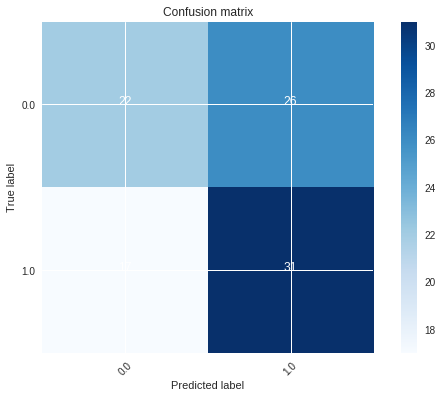

In [125]:
retModels, trainX, trainY, testX, testY, df = trainProduct(X+'.npy', Y+'.npy')

In [130]:
df.sort_values('accTEST', axis=0, ascending=False)#.query('wide==20')

,accTEST,accTRAIN,alpha,epsilon,eta0,fit_intercept,l1_ratio,learning_rate,loss,penalty,power_t,shuffle,time,tol
559,0.552083,0.544509,0.001,0.010,0.3,0.0,0.25,optimal,log,elasticnet,0.25,1.0,0.009044,0.0001
1327,0.552083,0.544509,0.001,0.100,0.1,0.0,0.25,optimal,log,elasticnet,0.25,1.0,0.045349,0.0001
943,0.552083,0.544509,0.001,0.001,0.2,0.0,0.25,optimal,log,elasticnet,0.25,1.0,0.006606,0.0001
1709,0.552083,0.544509,0.001,0.100,0.3,0.0,0.25,optimal,log,elasticnet,0.50,1.0,0.021343,0.0001
1711,0.552083,0.544509,0.001,0.100,0.3,0.0,0.25,optimal,log,elasticnet,0.25,1.0,0.008853,0.0001
941,0.552083,0.544509,0.001,0.001,0.2,0.0,0.25,optimal,log,elasticnet,0.50,1.0,0.099212,0.0001
1135,0.552083,0.544509,0.001,0.001,0.3,0.0,0.25,optimal,log,elasticnet,0.25,1.0,0.127301,0.0001
365,0.552083,0.544509,0.001,0.010,0.2,0.0,0.25,optimal,log,elasticnet,0.50,1.0,0.030622,0.0001
1133,0.552083,0.544509,0.001,0.001,0.3,0.0,0.25,optimal,log,elasticnet,0.50,1.0,0.066477,0.0001
557,0.552083,0.544509,0.001,0.010,0.3,0.0,0.25,optimal,log,elasticnet,0.50,1.0,0.071225,0.0001


ab hier : TESTS MIT DATEN

In [126]:
data = pd.read_pickle('Zalando_values_RSI_Trend.pkl')

In [127]:
print data.columns

Index([u'Close_prev', u'Volume_prev', u'RSI', u'aroon_up', u'aroon_down',
       u'aroon_up_mean', u'aroon_down_mean', u'signal_up', u'signal_down',
       u'Widerstand', u'Unterstuetzung', u'Stabil', u'countW', u'countU',
       u'countS', u'Trend'],
      dtype='object')


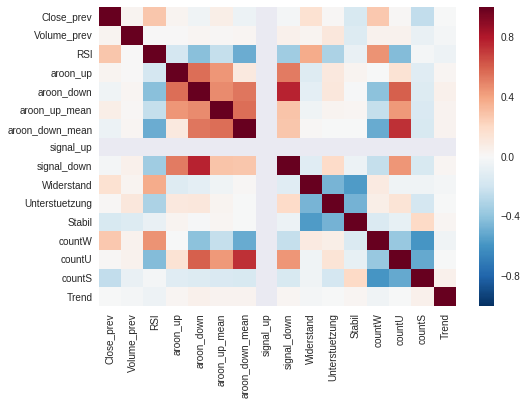

Close_prev        -0.006504
Volume_prev       -0.017100
RSI               -0.050223
aroon_up           0.016273
aroon_down         0.050353
aroon_up_mean      0.033703
aroon_down_mean    0.037773
signal_up               NaN
signal_down        0.015725
Widerstand        -0.017627
Unterstuetzung    -0.002888
Stabil             0.020208
countW            -0.044804
countU            -0.004630
countS             0.050575
Trend              1.000000
Name: Trend, dtype: float64

In [129]:
corr_map = data.corr()
sns.heatmap(corr_map)
plt.show()

corr_map['Trend']

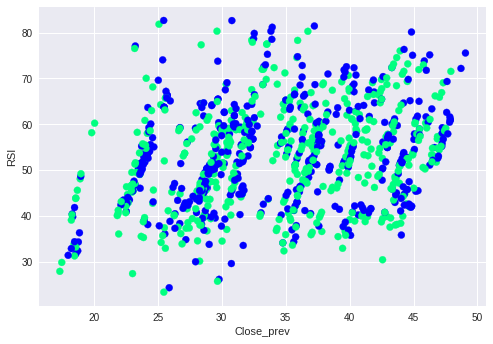

In [378]:
plt.scatter(data['Close_prev'], data['RSI'], c=data['Trend'],cmap=plt.cm.winter)
plt.xlabel('Close_prev')
plt.ylabel('RSI')
plt.show()

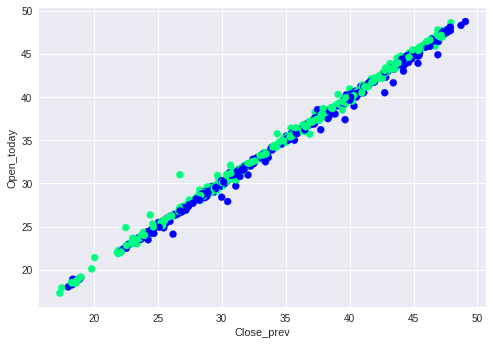

In [379]:
plt.scatter(data['Close_prev'], data['Open_today'], c=data['Trend'],cmap=plt.cm.winter)
plt.xlabel('Close_prev')
plt.ylabel('Open_today')
plt.show()

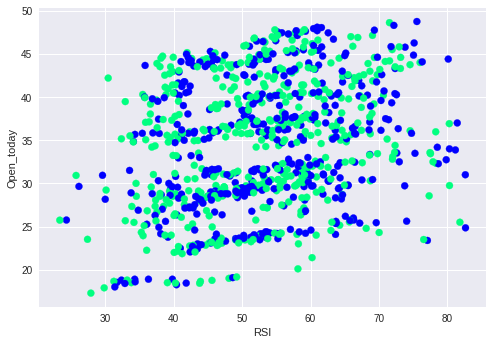

In [380]:
plt.scatter(data['RSI'], data['Open_today'], c=data['Trend'],cmap=plt.cm.winter)
plt.xlabel('RSI')
plt.ylabel('Open_today')
plt.show()

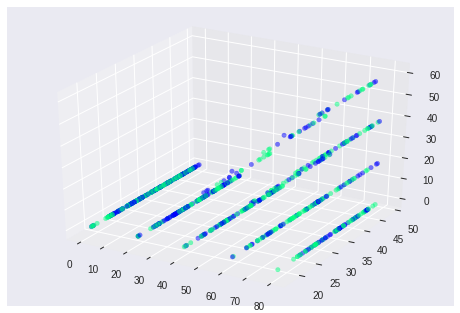

In [381]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['aroon_down'], data['Close_prev'], data['aroon_up'], c=data['Trend'], cmap=plt.cm.winter, alpha=0.5)
plt.show()

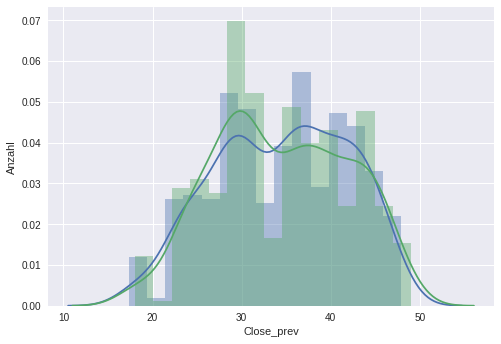

In [382]:
sns.distplot(data.loc[data.Trend==1]['Close_prev'],15)
sns.distplot(data.loc[data.Trend==0]['Close_prev'],15)
plt.xlabel("Close_prev")
plt.ylabel('Anzahl')
plt.show()

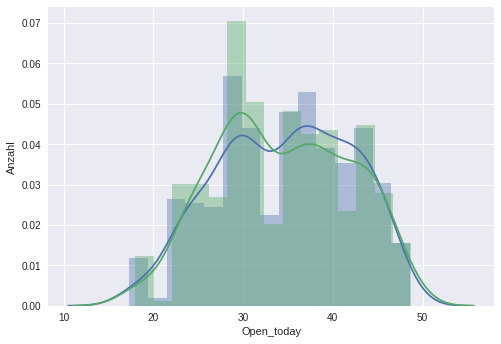

In [383]:
sns.distplot(data.loc[data.Trend==1]['Open_today'],15)
sns.distplot(data.loc[data.Trend==0]['Open_today'],15)
plt.xlabel("Open_today")
plt.ylabel('Anzahl')
plt.show()

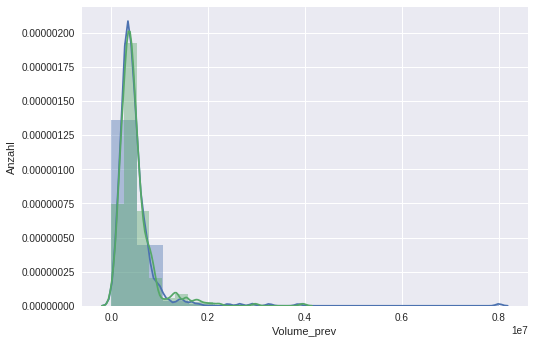

In [94]:
sns.distplot(data.loc[data.Trend==1]['Volume_prev'],15)
sns.distplot(data.loc[data.Trend==0]['Volume_prev'],15)
plt.xlabel("Volume_prev")
plt.ylabel('Anzahl')
plt.show()

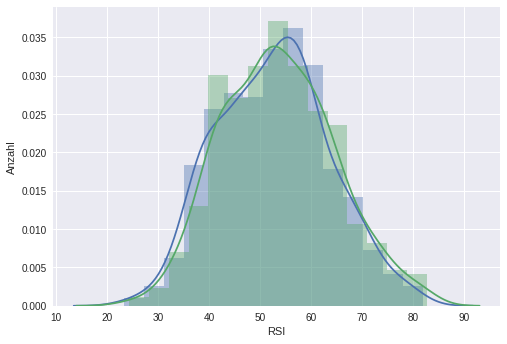

In [384]:
sns.distplot(data.loc[data.Trend==1]['RSI'],15)
sns.distplot(data.loc[data.Trend==0]['RSI'],15)
plt.xlabel("RSI")
plt.ylabel('Anzahl')
plt.show()

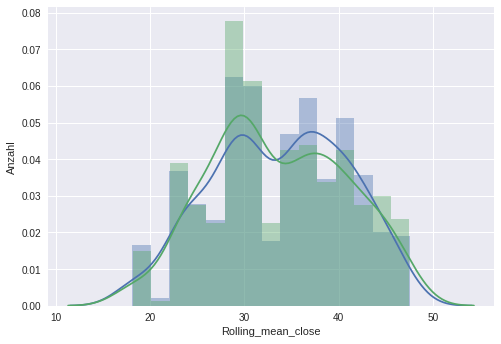

In [96]:
sns.distplot(data.loc[data.Trend==1]['Rolling_mean_close'],15)
sns.distplot(data.loc[data.Trend==0]['Rolling_mean_close'],15)
plt.xlabel("Rolling_mean_close")
plt.ylabel('Anzahl')
plt.show()

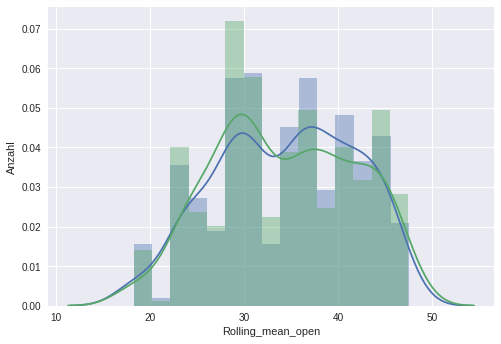

In [385]:
sns.distplot(data.loc[data.Trend==1]['Rolling_mean_open'],15)
sns.distplot(data.loc[data.Trend==0]['Rolling_mean_open'],15)
plt.xlabel("Rolling_mean_open")
plt.ylabel('Anzahl')
plt.show()

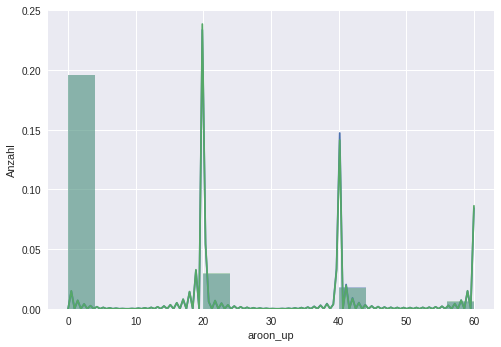

In [358]:
sns.distplot(data.loc[data.Trend==1]['aroon_up'],15)
sns.distplot(data.loc[data.Trend==0]['aroon_up'],15)
plt.xlabel("aroon_up")
plt.ylabel('Anzahl')
plt.show()

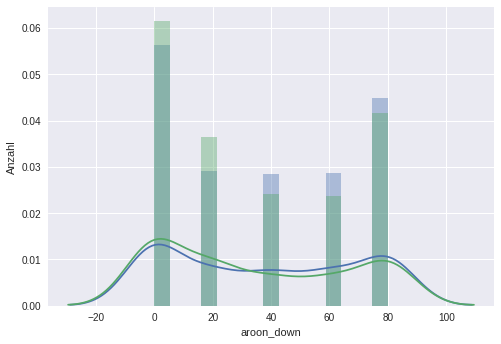

In [386]:
sns.distplot(data.loc[data.Trend==1]['aroon_down'],15)
sns.distplot(data.loc[data.Trend==0]['aroon_down'],15)
plt.xlabel("aroon_down")
plt.ylabel('Anzahl')
plt.show()

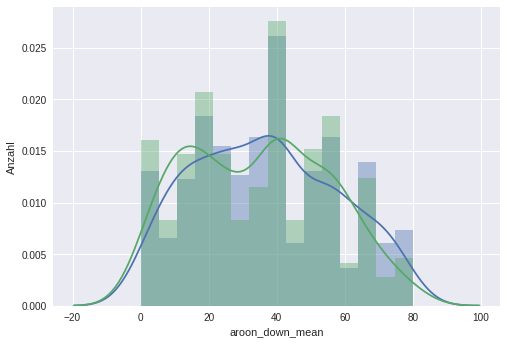

In [360]:
sns.distplot(data.loc[data.Trend==1]['aroon_down_mean'],15)
sns.distplot(data.loc[data.Trend==0]['aroon_down_mean'],15)
plt.xlabel("aroon_down_mean")
plt.ylabel('Anzahl')
plt.show()

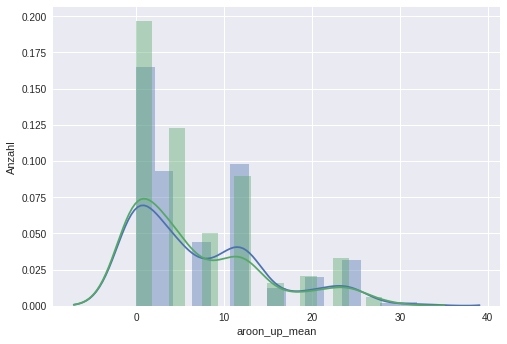

In [387]:
sns.distplot(data.loc[data.Trend==1]['aroon_up_mean'],15)
sns.distplot(data.loc[data.Trend==0]['aroon_up_mean'],15)
plt.xlabel("aroon_up_mean")
plt.ylabel('Anzahl')
plt.show()

In [389]:
print data.head()
print data.tail()

    Close_prev  Open_today  Volume_prev  Rolling_mean_close  \
15   18.750000   18.795000     145330.0             18.3985   
16   18.600000   18.530001     145788.0             18.4735   
17   18.500000   18.655001     165208.0             18.5285   
18   18.799999   18.900000     112577.0             18.5535   
19   18.590000   18.799999     134280.0             18.5115   

    Rolling_mean_open        RSI  aroon_up  aroon_down  aroon_up_mean  \
15            18.4720  32.349166       0.0         0.0            4.0   
16            18.5245  31.691980       0.0        40.0            4.0   
17            18.5835  31.236385       0.0        20.0            4.0   
18            18.6165  34.288329       0.0         0.0            0.0   
19            18.5795  33.178251       0.0        60.0            0.0   

    aroon_down_mean  signal_up  signal_down  Trend  
15             12.0          0            0      0  
16             20.0          0            0      0  
17             24.0    

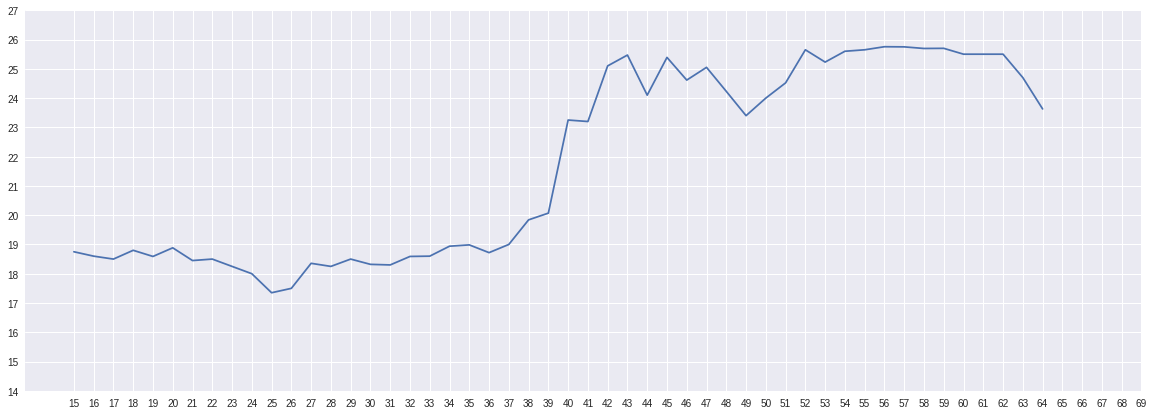

In [39]:
plt.figure(figsize=(20,7))
plt.plot(data.Close_prev[0:50])
plt.xticks(np.arange(15, 70, 1.0))
plt.yticks(np.arange(14, 28, 1.0))
plt.show()

In [103]:
kurse = pd.read_csv('ZalandoSE_Xetra.csv')

In [104]:
print kurse.columns

Index([u'Date', u'Open', u'High', u'Low', u'Close', u'Adj Close', u'Volume'], dtype='object')


In [135]:
print data.columns

Index([u'Close_prev', u'Open_today', u'Volume_prev', u'Rolling_mean_close',
       u'Rolling_mean_open', u'RSI', u'Trend'],
      dtype='object')


In [364]:
aroon_up, aroon_down = aroon(data['Close_prev'], 5)

In [365]:
len(aroon_up)

867

In [366]:
len(data)

867

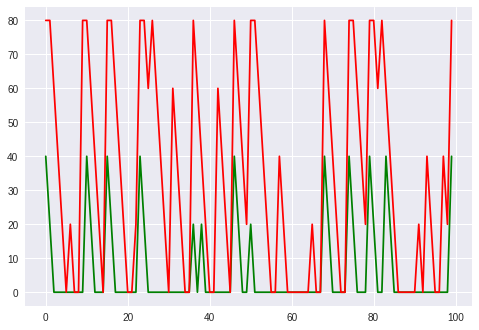

In [367]:
plt.plot(aroon_up[50:150], c="green")
plt.plot(aroon_down[50:150], c="red")
plt.show()

In [204]:
au = pd.DataFrame(aroon_up)
print au.head(50)

       0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10  50.0
11  40.0
12  30.0
13  20.0
14  10.0
15   0.0
16  10.0
17   0.0
18   0.0
19   0.0
20   0.0
21   0.0
22   0.0
23   0.0
24   0.0
25   0.0
26   0.0
27   0.0
28   0.0
29   0.0
30   0.0
31   0.0
32   0.0
33   0.0
34   0.0
35   0.0
36   0.0
37  10.0
38   0.0
39   0.0
40   0.0
41   0.0
42   0.0
43   0.0
44   0.0
45   0.0
46   0.0
47   0.0
48   0.0
49  20.0


In [184]:
autest = au.shift(10)
print len(autest)
print autest.head(15)

857
       0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10  50.0
11  40.0
12  30.0
13  20.0
14  10.0


In [190]:
au.index = au.index+10